# COMP5495 Robot Learning - Project part 1

Andrea Pierré

ID: 02181909

## Initialization

In [1]:
from pathlib import Path
import ipywidgets as widgets
from tqdm.auto import tqdm
from mcap_ros2.reader import read_ros2_messages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.interpolate import make_splrep
from scipy import signal
from movement_primitives.promp import ProMP
from IPython.display import Video

In [2]:
# %matplotlib ipympl

## Pick-and-Place task video

In [3]:
Video("./demo.mp4", height=600)

## Select demonstrations

The demonstrations are collected on ROS with the follwing command and saved as MCAP files:
```
ros2 bag record /tf /joint_states -o bag_files/rosbag2_$$(date +"%Y-%m-%d_%H-%M-%S")
```

In [4]:
data_path = Path("demos") / "ur5e-picknplace-right2left"
data_path.exists()

True

In [5]:
demos_filepaths = list(data_path.glob("**/*.mcap"))
demos_filepaths

[PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_06/rosbag2_2025_03_13-22_07_06_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_40/rosbag2_2025_03_13-22_07_40_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_12/rosbag2_2025_03_13-22_08_12_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_45/rosbag2_2025_03_13-22_08_45_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_09_18/rosbag2_2025_03_13-22_09_18_0.mcap')]

In [6]:
selection_widget = widgets.SelectMultiple(
    options=demos_filepaths,
    value=[],
    rows=10,
    description="Data files",
    disabled=False,
    layout=widgets.Layout(width="90%"),
)
display(selection_widget)

SelectMultiple(description='Data files', layout=Layout(width='90%'), options=(PosixPath('demos/ur5e-picknplace…

In [7]:
selected_files = selection_widget.value
selected_files

(PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_06/rosbag2_2025_03_13-22_07_06_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_40/rosbag2_2025_03_13-22_07_40_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_12/rosbag2_2025_03_13-22_08_12_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_45/rosbag2_2025_03_13-22_08_45_0.mcap'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_09_18/rosbag2_2025_03_13-22_09_18_0.mcap'))

## Read & parse MCAP files & export to HDF5

In [8]:
hdf_key_raw = "raw"

In [9]:
def parse_MCAP(rosbag_file):
    # Reading from a MCAP file
    x = []
    y = []
    z = []
    timestamps = []
    for msg in read_ros2_messages(rosbag_file):
        if msg.channel.topic == "/tf":
            transforms = msg.ros_msg.transforms
            for transfo in transforms:
                # if transfo.header.frame_id == "tool0_controller":
                if transfo.child_frame_id == "tool0_controller":
                    x.append(transfo.transform.translation.x)
                    y.append(transfo.transform.translation.y)
                    z.append(transfo.transform.translation.z)

                    # Time
                    time_sec = transfo.header.stamp.sec
                    time_nanosec = transfo.header.stamp.nanosec
                    timestamp = pd.Timestamp(
                        time_sec, unit="s", tz="EST"
                    ) + pd.to_timedelta(time_nanosec, unit="ns")
                    timestamps.append(timestamp)

    # Convert to dataframe
    df = pd.DataFrame({"x": x, "y": y, "z": z, "timestamps": timestamps})
    total_sec = (df.timestamps - df.timestamps.min()).transform(
        lambda x: x.total_seconds()
    )
    df["total_sec"] = total_sec

    # Save as HDF5
    raw_filepath = rosbag_file.parent / "demo.h5"
    df.to_hdf(raw_filepath, key=hdf_key_raw)
    return df

In [10]:
for filepath in tqdm(selected_files):
    parse_MCAP(filepath)

  0%|          | 0/5 [00:00<?, ?it/s]

## Visualize the demonstrations

In [11]:
demos_filepaths = list(data_path.glob("**/*.h5"))
demos_filepaths

[PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_06/demo.h5'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_07_40/demo.h5'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_12/demo.h5'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_08_45/demo.h5'),
 PosixPath('demos/ur5e-picknplace-right2left/rosbag2_2025_03_13-22_09_18/demo.h5')]

In [12]:
df = pd.read_hdf(demos_filepaths[0], hdf_key_raw)
df

,x,y,z,timestamps,total_sec
0,0.106297,-0.528893,0.001312,2025-03-13 21:07:07.830549150-05:00,0.000000
1,0.106268,-0.528912,0.001331,2025-03-13 21:07:07.832537717-05:00,0.001988
2,0.106288,-0.528906,0.001322,2025-03-13 21:07:07.834535415-05:00,0.003986
3,0.106291,-0.528894,0.001309,2025-03-13 21:07:07.836565856-05:00,0.006016
4,0.106278,-0.528911,0.001337,2025-03-13 21:07:07.838569326-05:00,0.008020
...,...,...,...,...,...
9004,-0.245042,-0.470401,0.169661,2025-03-13 21:07:25.838570080-05:00,18.008020
9005,-0.245053,-0.470390,0.169649,2025-03-13 21:07:25.840579002-05:00,18.010029
9006,-0.245035,-0.470383,0.169663,2025-03-13 21:07:25.842588560-05:00,18.012039
9007,-0.245040,-0.470403,0.169643,2025-03-13 21:07:25.844580825-05:00,18.014031


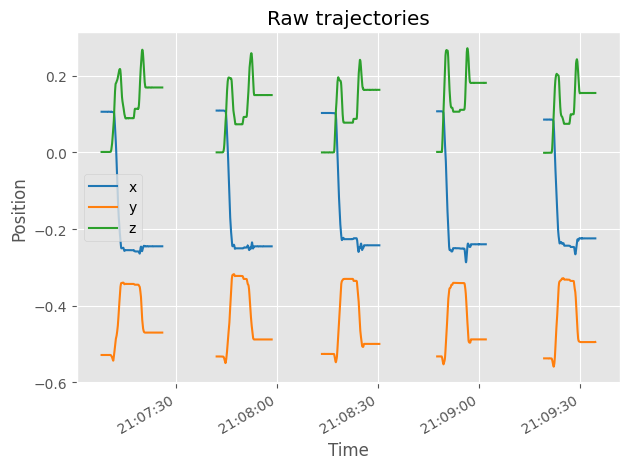

In [13]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    for demo_i, demo_v in enumerate(demos_filepaths):
        df = pd.read_hdf(demo_v, hdf_key_raw)

        if demo_i == 0:
            ax.plot(df.timestamps, df.x, label="x", color=cmap[0])
            ax.plot(df.timestamps, df.y, label="y", color=cmap[1])
            ax.plot(df.timestamps, df.z, label="z", color=cmap[2])
        else:
            ax.plot(df.timestamps, df.x, color=cmap[0])
            ax.plot(df.timestamps, df.y, color=cmap[1])
            ax.plot(df.timestamps, df.z, color=cmap[2])

    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.legend(loc="best")
    ax.set_title("Raw trajectories")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

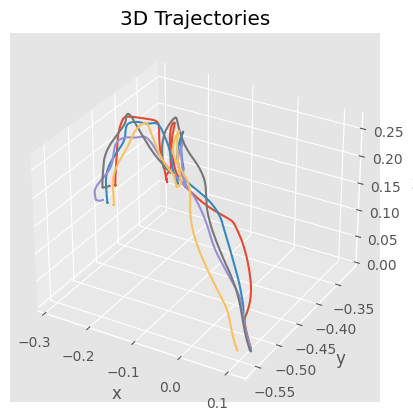

In [14]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    for demo_i, demo_v in enumerate(demos_filepaths):
        df = pd.read_hdf(demo_v, hdf_key_raw)
        ax.plot(df.x, df.y, df.z)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # fig.tight_layout()
    ax.set_title("3D Trajectories")
    plt.show()

## Smoothing

In [15]:
hdf_key_smooth = "smooth"

In [16]:
def smooth_traj(demo_filepath, nb_points=500, smoothing=0.001):
    df = pd.read_hdf(demo_filepath, hdf_key_raw)
    total_sec_interp = np.linspace(df.total_sec[0], df.total_sec.iloc[-1], nb_points)
    df_smooth = pd.DataFrame(
        {
            "sec": total_sec_interp,
            "x": make_splrep(df.total_sec, df.x, s=smoothing)(total_sec_interp),
            "y": make_splrep(df.total_sec, df.y, s=smoothing)(total_sec_interp),
            "z": make_splrep(df.total_sec, df.z, s=smoothing)(total_sec_interp),
        }
    )
    df_smooth.to_hdf(demo_filepath, key=hdf_key_smooth)
    return df_smooth

In [17]:
for filepath in tqdm(demos_filepaths):
    smooth_traj(filepath, nb_points=500, smoothing=0.001)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
df_smooth = pd.read_hdf(demos_filepaths[0], hdf_key_smooth)
df_smooth

,sec,x,y,z
0,0.000000,0.106374,-0.529170,0.001293
1,0.036104,0.106357,-0.529115,0.001297
2,0.072209,0.106341,-0.529064,0.001301
3,0.108313,0.106327,-0.529018,0.001305
4,0.144417,0.106314,-0.528976,0.001308
...,...,...,...,...
495,17.871629,-0.244985,-0.470414,0.169648
496,17.907733,-0.244973,-0.470417,0.169646
497,17.943837,-0.244961,-0.470420,0.169644
498,17.979942,-0.244948,-0.470424,0.169642


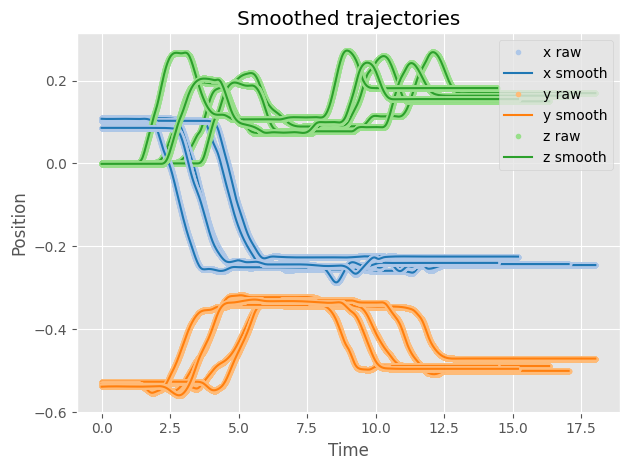

In [19]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab20").colors

    for demo_i, demo_v in enumerate(demos_filepaths):
        df = pd.read_hdf(demo_v, hdf_key_raw)
        df_smooth = pd.read_hdf(demo_v, hdf_key_smooth)

        if demo_i == 0:
            ax.plot(df.total_sec, df.x, ".", label="x raw", color=cmap[1])
            ax.plot(df_smooth.sec, df_smooth.x, "-", label="x smooth", color=cmap[0])
            ax.plot(df.total_sec, df.y, ".", label="y raw", color=cmap[3])
            ax.plot(df_smooth.sec, df_smooth.y, "-", label="y smooth", color=cmap[2])
            ax.plot(df.total_sec, df.z, ".", label="z raw", color=cmap[5])
            ax.plot(df_smooth.sec, df_smooth.z, "-", label="z smooth", color=cmap[4])
        else:
            ax.plot(df.total_sec, df.x, ".", color=cmap[1])
            ax.plot(df_smooth.sec, df_smooth.x, "-", color=cmap[0])
            ax.plot(df.total_sec, df.y, ".", color=cmap[3])
            ax.plot(df_smooth.sec, df_smooth.y, "-", color=cmap[2])
            ax.plot(df.total_sec, df.z, ".", color=cmap[5])
            ax.plot(df_smooth.sec, df_smooth.z, "-", color=cmap[4])

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("Smoothed trajectories")
    fig.tight_layout()
    plt.show()

## LfD model - ProMP

In [20]:
for demo_i, demo_v in enumerate(demos_filepaths):
    df_smooth = pd.read_hdf(demo_v, hdf_key_smooth)

    if demo_i == 0:
        Ts = df_smooth.sec.to_numpy()
        Xs = df_smooth.x.to_numpy()
        Ys = df_smooth.y.to_numpy()
        Zs = df_smooth.z.to_numpy()
    else:
        Ts = np.vstack((Ts, df_smooth.sec.to_numpy()))
        Xs = np.vstack((Xs, df_smooth.x.to_numpy()))
        Ys = np.vstack((Ys, df_smooth.y.to_numpy()))
        Zs = np.vstack((Zs, df_smooth.z.to_numpy()))

Ts.shape, Xs.shape, Ys.shape, Zs.shape

((5, 500), (5, 500), (5, 500), (5, 500))

In [21]:
n_weights = 100
n_demos = len(demos_filepaths)

promp_x = ProMP(n_dims=1, n_weights_per_dim=n_weights)
promp_x.imitate(Ts, Xs)
X_mean = promp_x.mean_trajectory(Ts[0, :])
X_conf = 1.96 * np.sqrt(promp_x.var_trajectory(Ts[0, :]))

promp_y = ProMP(n_dims=1, n_weights_per_dim=n_weights)
promp_y.imitate(Ts, Ys)
Y_mean = promp_y.mean_trajectory(Ts[0, :])
Y_conf = 1.96 * np.sqrt(promp_y.var_trajectory(Ts[0, :]))

promp_z = ProMP(n_dims=1, n_weights_per_dim=n_weights)
promp_z.imitate(Ts, Zs)
Z_mean = promp_z.mean_trajectory(Ts[0, :])
Z_conf = 1.96 * np.sqrt(promp_z.var_trajectory(Ts[0, :]))

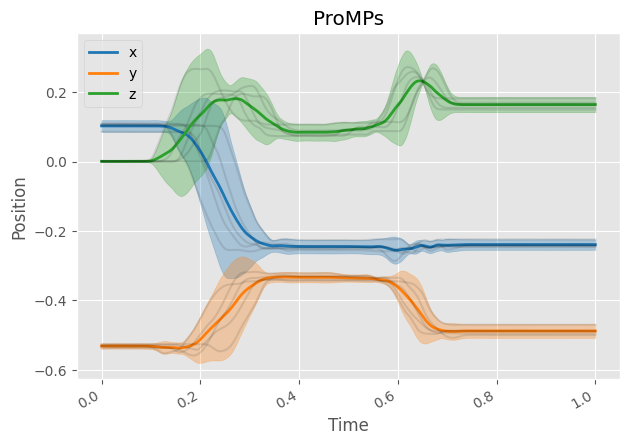

In [22]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    ax.fill_between(
        Ts[0, :],
        (X_mean - X_conf).ravel(),
        (X_mean + X_conf).ravel(),
        alpha=0.3,
        color=cmap[0],
    )
    ax.plot(Ts[0, :], X_mean, lw=2, label="x", color=cmap[0])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Xs[di, :], c="k", alpha=0.1)

    ax.fill_between(
        Ts[0, :],
        (Y_mean - Y_conf).ravel(),
        (Y_mean + Y_conf).ravel(),
        alpha=0.3,
        color=cmap[1],
    )
    ax.plot(Ts[0, :], Y_mean, lw=2, label="y", color=cmap[1])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Ys[di, :], c="k", alpha=0.1)

    ax.fill_between(
        Ts[0, :],
        (Z_mean - Z_conf).ravel(),
        (Z_mean + Z_conf).ravel(),
        alpha=0.3,
        color=cmap[2],
    )
    ax.plot(Ts[0, :], Z_mean, lw=2, label="z", color=cmap[2])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Zs[di, :], c="k", alpha=0.1)

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("ProMPs")
    fig.tight_layout()
    fig.autofmt_xdate()
    plt.show()

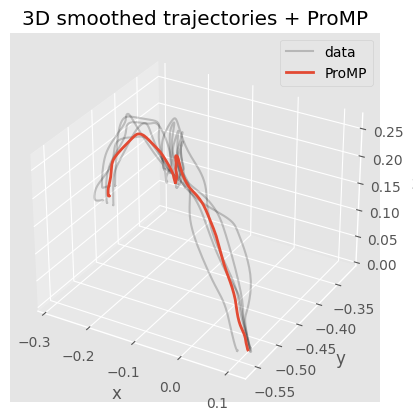

In [23]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    for demo_i, demo_v in enumerate(demos_filepaths):
        df = pd.read_hdf(demo_v, hdf_key_smooth)
        if demo_i == 0:
            ax.plot(df.x, df.y, df.z, c="k", alpha=0.2, label="data")
        else:
            ax.plot(df.x, df.y, df.z, c="k", alpha=0.2)

    ax.plot(X_mean, Y_mean, Z_mean, lw=2, label="ProMP")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # fig.tight_layout()
    ax.set_title("3D smoothed trajectories + ProMP")
    ax.legend(loc="best")
    plt.show()

## New initial point

In [24]:
x_conditional_cov = np.array([0])
y_conditional_cov = np.array([0])
z_conditional_cov = np.array([0])
x_ini = 0.15
y_ini = -0.6
z_ini = 0.01

cpromp_x = promp_x.condition_position(
    y_mean=np.array([x_ini]), y_cov=x_conditional_cov, t=0.0, t_max=1.0
)
X_cmean = cpromp_x.mean_trajectory(Ts[0, :])
X_cconf = 1.96 * np.sqrt(cpromp_x.var_trajectory(Ts[0, :]))

cpromp_y = promp_y.condition_position(
    y_mean=np.array([y_ini]), y_cov=y_conditional_cov, t=0.0, t_max=1.0
)
Y_cmean = cpromp_y.mean_trajectory(Ts[0, :])
Y_cconf = 1.96 * np.sqrt(cpromp_y.var_trajectory(Ts[0, :]))

cpromp_z = promp_z.condition_position(
    y_mean=np.array([z_ini]), y_cov=z_conditional_cov, t=0.0, t_max=1.0
)
Z_cmean = cpromp_z.mean_trajectory(Ts[0, :])
Z_cconf = 1.96 * np.sqrt(cpromp_z.var_trajectory(Ts[0, :]))

In [25]:
np.isnan(X_cmean).all(), np.isnan(X_cconf).all()

(np.False_, np.False_)

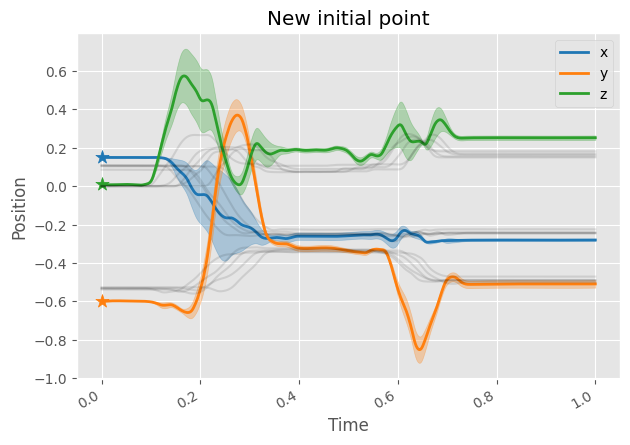

In [26]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    ax.scatter([0], [x_ini], marker="*", s=100, color=cmap[0])
    ax.fill_between(
        Ts[0, :],
        (X_cmean - X_cconf).ravel(),
        (X_cmean + X_cconf).ravel(),
        alpha=0.3,
        color=cmap[0],
    )
    ax.plot(Ts[0, :], X_cmean, lw=2, label="x", color=cmap[0])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Xs[di, :], c="k", alpha=0.1)

    ax.scatter([0], [y_ini], marker="*", s=100, color=cmap[1])
    ax.fill_between(
        Ts[0, :],
        (Y_cmean - Y_cconf).ravel(),
        (Y_cmean + Y_cconf).ravel(),
        alpha=0.3,
        color=cmap[1],
    )
    ax.plot(Ts[0, :], Y_cmean, lw=2, label="y", color=cmap[1])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Ys[di, :], c="k", alpha=0.1)

    ax.scatter([0], [z_ini], marker="*", s=100, color=cmap[2])
    ax.fill_between(
        Ts[0, :],
        (Z_cmean - Z_cconf).ravel(),
        (Z_cmean + Z_cconf).ravel(),
        alpha=0.3,
        color=cmap[2],
    )
    ax.plot(Ts[0, :], Z_cmean, lw=2, label="z", color=cmap[2])
    for di, _ in enumerate(demos_filepaths):
        ax.plot(Ts[di, :], Zs[di, :], c="k", alpha=0.1)

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("New initial point")
    fig.tight_layout()
    fig.autofmt_xdate()
    plt.show()

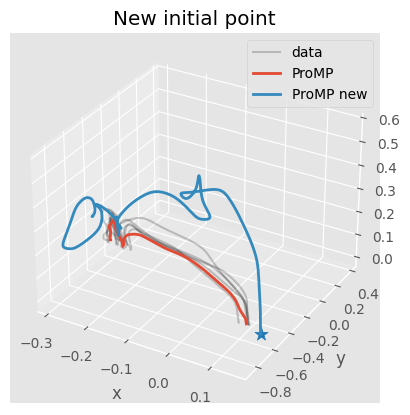

In [28]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    for demo_i, demo_v in enumerate(demos_filepaths):
        df = pd.read_hdf(demo_v, hdf_key_smooth)
        if demo_i == 0:
            ax.plot(df.x, df.y, df.z, c="k", alpha=0.2, label="data")
        else:
            ax.plot(df.x, df.y, df.z, c="k", alpha=0.2)

    ax.plot(X_mean, Y_mean, Z_mean, lw=2, label="ProMP")
    ax.plot(X_cmean, Y_cmean, Z_cmean, lw=2, label="ProMP new")
    ax.scatter(x_ini, y_ini, z_ini, marker="*", s=100, color=cmap[0])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # fig.tight_layout()
    ax.set_title("New initial point")
    ax.legend(loc="best")
    plt.show()